# DL Mini Project

## Submitted By: Ishwant Singh Bhayana(isb5064), Prajna Ravindra Nayak(pn2224), Parth Mehta(pjm9767) 

## ResNet Model with the best performance from out hyperparameter sweep

In [12]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [13]:
class Block(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetModel(nn.Module):
    def __init__(self, block, num_blocks, strides, num_classes=10):
        super(ResNetModel, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=strides[0])
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=strides[1])
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=strides[2])
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=strides[3])
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        if num_blocks > 0:
            strides = [stride] + [1]*(num_blocks-1)
            layers = []
            for stride in strides:
                layers.append(block(self.in_planes, planes, stride))
                self.in_planes = planes * block.expansion
            return nn.Sequential(*layers)
        else:
            # Use a single convolution layer instead of a residual block when num_blocks is 0
            layer =  nn.Sequential(nn.Conv2d(self.in_planes, planes, kernel_size=1, stride=stride, padding=1, bias=False),
                          nn.BatchNorm2d(planes))
            self.in_planes = planes * block.expansion
            return layer


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Reference code: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # start with 0, will update as better acc is achieved
start_epoch = 0

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Reference code: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

Files already downloaded and verified
Files already downloaded and verified


In [15]:
learning_rate = 0.1

# Train
def train_one_epoch(net, optimizer, criterion):
    
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(trainloader):

        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {100.*correct/total:.2f}%')

    return train_loss, 100.*correct/total

def test(net, optimizer, criterion):

    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():

        for batch_idx, (inputs, labels) in enumerate(testloader):

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {100.*correct/total:.2f}%')

        return test_loss, 100.*correct/total

    #save the checkpoint
    acc = 100.*correct/total
    if acc > best_acc: #when curr acc is the best yet
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

# Reference code: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [16]:
num_blocks=[2, 3, 2, 0]
learning_rate = 0.02
strides=[1,2,2,2]

net = ResNetModel(Block, num_blocks, strides=strides)
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [17]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
NUM_OF_EPOCHS = 120

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate,
                    momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

train_accuracy_history = []
train_loss_history = []
test_accuracy_history = []
test_loss_history = []

for epoch in range(NUM_OF_EPOCHS):
    
    start_time = time.time()

    train_loss, train_acc = train_one_epoch(net, optimizer, criterion)
    test_loss, test_acc = test(net, optimizer, criterion)

    train_accuracy_history.append(train_acc)
    train_loss_history.append(train_loss)
    test_accuracy_history.append(test_acc)
    test_loss_history.append(test_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}minutes {epoch_secs}seconds')

    scheduler.step()

	Train Loss: 79.241 | Train Acc: 93.01%
	Test Loss: 34.429 | Test Acc: 88.57%
Epoch: 01 | Epoch Time: 0.0minutes 40.15053677558899seconds
	Train Loss: 77.497 | Train Acc: 93.00%
	Test Loss: 47.252 | Test Acc: 85.61%
Epoch: 02 | Epoch Time: 0.0minutes 39.02273893356323seconds
	Train Loss: 72.113 | Train Acc: 93.44%
	Test Loss: 36.606 | Test Acc: 88.69%
Epoch: 03 | Epoch Time: 0.0minutes 39.86514139175415seconds
	Train Loss: 69.275 | Train Acc: 93.90%
	Test Loss: 29.976 | Test Acc: 90.31%
Epoch: 04 | Epoch Time: 0.0minutes 39.89954495429993seconds
	Train Loss: 67.279 | Train Acc: 94.15%
	Test Loss: 40.932 | Test Acc: 88.44%
Epoch: 05 | Epoch Time: 0.0minutes 40.6359646320343seconds
	Train Loss: 65.660 | Train Acc: 94.16%
	Test Loss: 38.821 | Test Acc: 88.71%
Epoch: 06 | Epoch Time: 0.0minutes 39.449806928634644seconds
	Train Loss: 62.803 | Train Acc: 94.48%
	Test Loss: 41.172 | Test Acc: 87.73%
Epoch: 07 | Epoch Time: 0.0minutes 39.96239900588989seconds
	Train Loss: 60.950 | Train Acc: 9

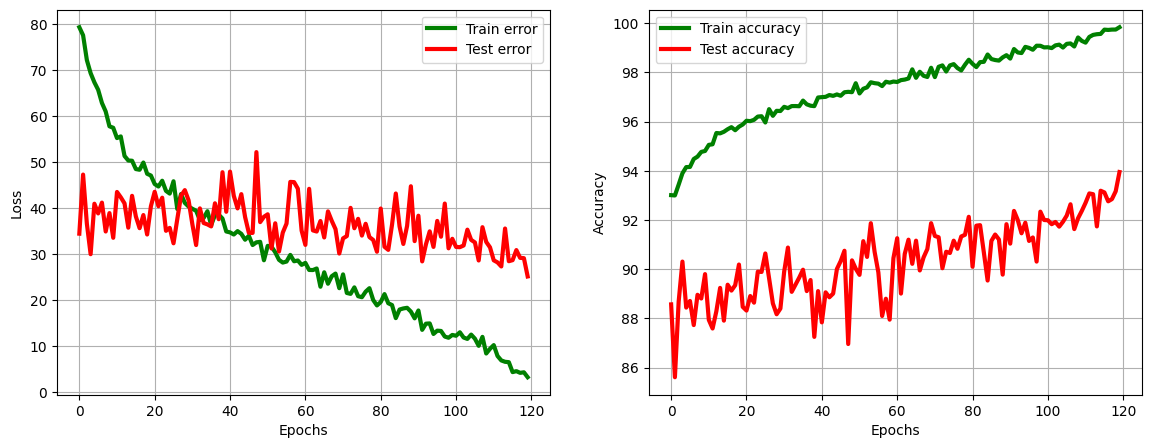

In [31]:
fig = plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(range(NUM_OF_EPOCHS),train_loss_history,'g-',linewidth=3,label='Train error')
plt.plot(range(NUM_OF_EPOCHS),test_loss_history,'r-',linewidth=3,label='Test error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(NUM_OF_EPOCHS),train_accuracy_history,'g-',linewidth=3,label='Train accuracy')
plt.plot(range(NUM_OF_EPOCHS),test_accuracy_history,'r-',linewidth=3,label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()